# Exploratory Data Analysis of Stimulus Triggered Averages
*Ian Malone*

### Load data and check structure

In [1]:
import pandas as pd

df_sta = pd.read_csv('C:\\Users\\Ian\\Google Drive\\IanGMalone\\UF\\Lab\DataAndFigures\\Analysis\\df_STA_2020_11_19.csv')
df_sta.head()

,Animal,Day,Side,Stim_Amplitude,Sample,STA_Amplitude
0,S01,D04,Left,100.0,0,0.066743
1,S01,D04,Left,100.0,1,0.076911
2,S01,D04,Left,100.0,2,0.086139
3,S01,D04,Left,100.0,3,0.094280
4,S01,D04,Left,100.0,4,0.101673


In [2]:
df_sta.dtypes

Animal             object
Day                object
Side               object
Stim_Amplitude    float64
Sample              int64
STA_Amplitude     float64
dtype: object

#### We will only keep the left side EMG for analysis

In [3]:
df_sta = df_sta[df_sta["Side"] == 'Left']

In [4]:
print(df_sta.Animal.unique())
print(df_sta.Day.unique())
print(df_sta.Side.unique())
print(df_sta.Stim_Amplitude.unique())

['S01' 'S02' 'S03']
['D04' 'D06' 'D08']
['Left']
[100. 110. 120. 130. 140. 150. 160. 170. 180. 190. 200. 210. 220. 230.
 240. 250. 260. 270. 280. 290. 300. 310. 320. 330. 340. 350. 360. 370.
 380. 390. 400. 410. 420. 430. 440. 450. 460. 470. 480. 490. 500. 510.
 520. 530. 540. 550. 560. 570. 580. 590. 600.]


### 1) Waveform from stimulus triggered average for each current amplitude, each animal, each day

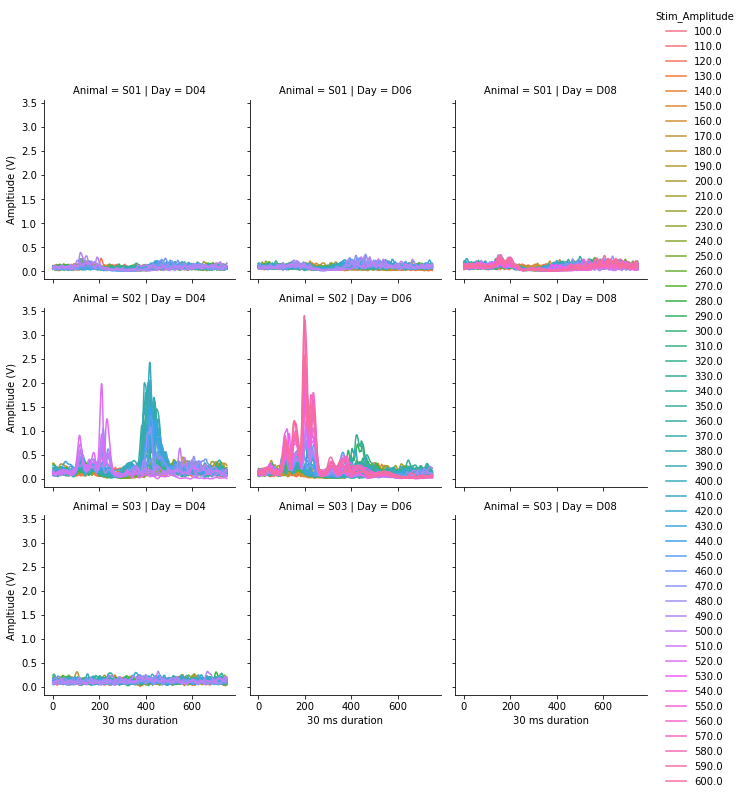

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.FacetGrid(df_sta, col='Day', row='Animal', hue='Stim_Amplitude')
g.map_dataframe(sns.lineplot, x='Sample', y='STA_Amplitude')
g.set_axis_labels('30 ms duration', 'Ampltiude (V)')
g.add_legend()

#### Observations
- Each animal will need to have MEPs viewed on a unique y-axis. While this will help in viewing the data, during analysis, animals with large scale EMG values will dominate and potentially obscure interesting group trends in MEP shape, latency, and longitudinal change.
- Another approach is to normalize all MEP values between 0 and 1. This must be done for each individual animal and all days must be included in the normalization to preserve day-to-day changes. However, this normalization prevents direct comparisons between animals. Use this if you only care about the change over time for animals and not the absolute comparison of EMG values betweeen animals. This may be a valid approach due to variability in electrodes, implantation, etc. preventing meaningful comparison of MEP magnitude between two animals.
- These files are large. The front-end amplifier uses a low-pass filter with 1 kHz 3 dB cutoff. Files are sampled at 25 kHz. Time and space can be saved while avoiding aliasing by downsampling to 5 kHz.

#### Plan
- Downsample files and check PSD before and after downsampling to ensure most information is preserved.
- 


In [40]:
t = pd.to_timedelta(df_sta.Sample, unit='T')
s = df_sta.set_index(t).groupby('Animal').resample('3T').last().reset_index(drop=True)
df_sta.size

1206000

### 2) AUC from stimulus triggered average for each current amplitude, each animal, each day

### 3) Peak to peak from stimulus triggered average for each current amplitude, each animal, each day

### 4) Latency from stimulus pulse to stimulus triggered average for each current amplitude, each animal, each day

### 5) Time domains of stimulus triggered average

### 6) Differences in any of these parameters based on time of day?

### 7) How are we going to present the impedance data in the Neilsen paper? I’m still not clear on this.

### 8) Additional things we can look at (e.g., wavelet, fft, etc.)
Look in manuscript file for notes on ideas. Also look in Daily Notes on OneNote for papers that did EMG analysis well.